In this project, we'll build a simple convolutional neural network for CIFAR-10 image classification. Code contained in this project was based on Tensorflow 1.2.1 and python 3.5. 

In [6]:
from urllib.request import urlretrieve
import time
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import tensorflow as tf

cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 6:
Image - Min Value: 7 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


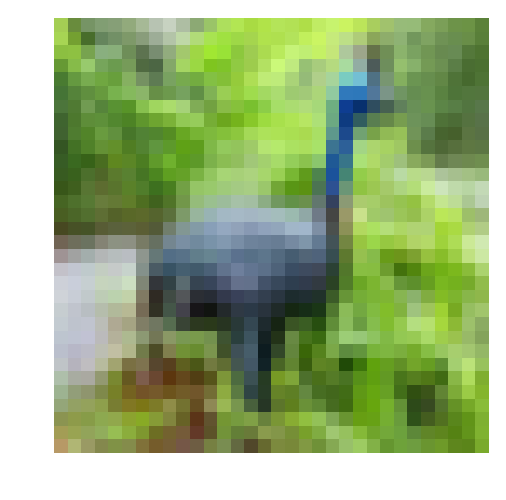

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 6
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

# Preprocess Data

## Normalize

In [8]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    return ( x - x.min() ) / ( x.max() - x.min() )

## One hot encode

In [9]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    output = np.zeros([len(x), 10])
    for idx, item in enumerate(x):
        output[idx, item] = 1
    return output

This above function is equivalent to tf.one_hot(x, 10), but tensorflow module can not be pickled so we're sticking with the above implementation.

## Preprocess Data
We will randomly shuffle the data, normalize them and save them in binary format.

In [10]:
import tensorflow as tf
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, one_hot_encode)

# Checkpoint
The above work is all saved so when we're revisiting this notebook we don't have to do those work again. We can start from here.

In [11]:
import pickle
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
batch_mean = np.mean(valid_features)
batch_std = np.std(valid_features)
valid_features = valid_features.astype(np.float32)
for ii in range(valid_features.shape[0]):
    valid_features[ii, :, :, :] = (valid_features[ii, :, :, :] - batch_mean) / batch_std

# Building the network

## Defining input

In [12]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    """
    return tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    """
    return tf.placeholder(tf.float32, [None, n_classes], "y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    """
    return tf.placeholder(tf.float32, None, "keep_prob")

## Convolution and maxpool layer

In [13]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    w = tf.get_variable("w", shape=[conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[3], conv_num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([conv_num_outputs], mean=0.0, stddev=0.1, dtype=tf.float32))
    
    wc = tf.nn.conv2d(x_tensor, w, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    z = tf.nn.bias_add(wc, b)
    
    return tf.nn.relu(z)


## Flatten layer
Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor. The output should be the shape (Batch Size, Flattened Image Size). Shortcut option: you can use classes from the TensorFlow Layers or TensorFlow Layers (contrib) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [14]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # reference : https://github.com/tensorflow/tensorflow/issues/7253
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], np.prod(x_tensor.get_shape().as_list()[1:])])
    
    # This also works
    #return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape[1:]).value])

## Fully connected layer

In [15]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    fc = tf.reshape(x_tensor, [-1, np.prod(x_tensor.get_shape().as_list()[1:])])
    
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    z = tf.add(tf.matmul(fc, w), b)
    
    return tf.nn.relu(z)

## Output layer

In [16]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    return tf.add(tf.matmul(x_tensor, w), b)


## Create the convolutional neural network model

In [17]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Convolution and maxpooling layers
    with tf.variable_scope("conv1"):
        conv1 = conv2d(x, 40, (3, 3), (1, 1))
        
    with tf.variable_scope("conv2"):
        conv2 = conv2d(conv1, 80, (3, 3), (1, 1))
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv2 = tf.nn.dropout(conv2, keep_prob)
    
    with tf.variable_scope("conv3"):
        conv3 = conv2d(conv2, 160, (3, 3), (1, 1))
    
    with tf.variable_scope("conv4"):
        conv4 = conv2d(conv3, 320, (3, 3), (1, 1))
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv4 = tf.nn.dropout(conv4, keep_prob)
    
    # Flatten Layer
    f = flatten(conv4)

    # Fully Connected layers
    with tf.variable_scope("fc1"):
        fc1 = fully_conn(f, 512)
        fc1 = tf.nn.dropout(fc1, keep_prob)
    with tf.variable_scope("fc2"):
        fc2 = fully_conn(fc1, 256)
        fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Output Layer
    with tf.variable_scope("out"):
        o = output(fc2, 10)
    
    # TODO: return output
    return o

## Build the network

In [18]:
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(epsilon=1e-04).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train network

In [19]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    """
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})

## Print Stats
It's important to evaluate the performance of model once in a while. If effect, we're feeding a small batch of data to the neural network through forward propagation and then caculate the accuracy of prediction. We don't want to do this too often as this slows down the overall process. It's important to keep in mind that since we're actually using the model for prediction but not training it, we need to set keep probability for dropout to 1 so we're not losing any connection between neurons. 

In [20]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    """
    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_acc = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

## Hyperparameters

In [21]:
epochs = 30
batch_size = 128
keep_probability = 0.5

## Train on a single CIFAR-10 batch

In [22]:
t1 = time.time()
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            batch_mean = np.mean(batch_features)
            batch_std = np.std(batch_features)
            batch_features = batch_features.astype(np.float32)
            for ii in range(batch_features.shape[0]):
                batch_features[ii, :, :, :] = (batch_features[ii, :, :, :] - batch_mean) / batch_std  
            start = time.time()
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            end = time.time()
            print('training one batch took: {:0.4f} seconds'.format(end-start))
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)
t2 = time.time()
print('total took:{:0.4f} seconds'.format(t2-t1))

Checking the Training on a Single Batch...
training one batch took: 0.6824 seconds
training one batch took: 0.0307 seconds
training one batch took: 0.0293 seconds
training one batch took: 0.0306 seconds
training one batch took: 0.0297 seconds
training one batch took: 0.0287 seconds
training one batch took: 0.0301 seconds
training one batch took: 0.0319 seconds
training one batch took: 0.0287 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0286 seconds
training one batch took: 0.0286 seconds
training one batch took: 0.0308 seconds
training one batch took: 0.0332 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0306 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0285 seconds
training one batch took: 0.0299 seconds
training one batch took: 0.0370 seconds
training one batch took: 0.0373 seconds
training one batch took: 0.0352 seconds
training one batch took: 0.0341 seconds
training one batch took: 0.0429 secon

training one batch took: 0.0349 seconds
training one batch took: 0.0350 seconds
training one batch took: 0.0365 seconds
training one batch took: 0.0338 seconds
training one batch took: 0.0329 seconds
training one batch took: 0.0331 seconds
training one batch took: 0.0309 seconds
training one batch took: 0.0302 seconds
training one batch took: 0.0290 seconds
training one batch took: 0.0313 seconds
training one batch took: 0.0121 seconds
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.1632 Validation Accuracy: 0.447000
training one batch took: 0.0295 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0289 seconds
training one batch took: 0.0293 seconds
training one batch took: 0.0306 seconds
training one batch took: 0.0287 seconds
training one batch took: 0.0293 seconds
training one batch took: 0.0321 seconds
training one batch took: 0.0332 seconds
training one batch took: 0.0333 seconds
training one batch took: 0.0340 seconds
training one batch took: 0.0348 seconds
trai

training one batch took: 0.0287 seconds
training one batch took: 0.0300 seconds
training one batch took: 0.0288 seconds
training one batch took: 0.0291 seconds
training one batch took: 0.0289 seconds
training one batch took: 0.0291 seconds
training one batch took: 0.0298 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0293 seconds
training one batch took: 0.0291 seconds
training one batch took: 0.0289 seconds
training one batch took: 0.0308 seconds
training one batch took: 0.0319 seconds
training one batch took: 0.0301 seconds
training one batch took: 0.0298 seconds
training one batch took: 0.0301 seconds
training one batch took: 0.0298 seconds
training one batch took: 0.0307 seconds
training one batch took: 0.0391 seconds
training one batch took: 0.0308 seconds
training one batch took: 0.0239 seconds
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.0354 Validation Accuracy: 0.577800
training one batch took: 0.0305 seconds
training one batch took: 0.0290 seconds
trai

training one batch took: 0.0316 seconds
training one batch took: 0.0291 seconds
training one batch took: 0.0296 seconds
training one batch took: 0.0291 seconds
training one batch took: 0.0289 seconds
training one batch took: 0.0286 seconds
training one batch took: 0.0300 seconds
training one batch took: 0.0290 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0298 seconds
training one batch took: 0.0297 seconds
training one batch took: 0.0301 seconds
training one batch took: 0.0313 seconds
training one batch took: 0.0315 seconds
training one batch took: 0.0310 seconds
training one batch took: 0.0297 seconds
training one batch took: 0.0296 seconds
training one batch took: 0.0299 seconds
training one batch took: 0.0319 seconds
training one batch took: 0.0301 seconds
training one batch took: 0.0300 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0298 seconds
training one batch took: 0.0328 seconds
training one batch took: 0.0302 seconds


training one batch took: 0.0308 seconds
training one batch took: 0.0300 seconds
training one batch took: 0.0306 seconds
training one batch took: 0.0303 seconds
training one batch took: 0.0302 seconds
training one batch took: 0.0303 seconds
training one batch took: 0.0321 seconds
training one batch took: 0.0309 seconds
training one batch took: 0.0307 seconds
training one batch took: 0.0305 seconds
training one batch took: 0.0303 seconds
training one batch took: 0.0309 seconds
training one batch took: 0.0337 seconds
training one batch took: 0.0302 seconds
training one batch took: 0.0309 seconds
training one batch took: 0.0304 seconds
training one batch took: 0.0304 seconds
training one batch took: 0.0333 seconds
training one batch took: 0.0327 seconds
training one batch took: 0.0319 seconds
training one batch took: 0.0304 seconds
training one batch took: 0.0302 seconds
training one batch took: 0.0364 seconds
training one batch took: 0.0300 seconds
training one batch took: 0.0304 seconds


training one batch took: 0.0296 seconds
training one batch took: 0.0317 seconds
training one batch took: 0.0302 seconds
training one batch took: 0.0318 seconds
training one batch took: 0.0352 seconds
training one batch took: 0.0325 seconds
training one batch took: 0.0390 seconds
training one batch took: 0.0331 seconds
training one batch took: 0.0332 seconds
training one batch took: 0.0369 seconds
training one batch took: 0.0323 seconds
training one batch took: 0.0329 seconds
training one batch took: 0.0331 seconds
training one batch took: 0.0318 seconds
training one batch took: 0.0328 seconds
training one batch took: 0.0305 seconds
training one batch took: 0.0334 seconds
training one batch took: 0.0336 seconds
training one batch took: 0.0293 seconds
training one batch took: 0.0291 seconds
training one batch took: 0.0362 seconds
training one batch took: 0.0332 seconds
training one batch took: 0.0336 seconds
training one batch took: 0.0339 seconds
training one batch took: 0.0324 seconds


training one batch took: 0.0295 seconds
training one batch took: 0.0414 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0291 seconds
training one batch took: 0.0292 seconds
training one batch took: 0.0291 seconds
training one batch took: 0.0324 seconds
training one batch took: 0.0296 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0292 seconds
training one batch took: 0.0314 seconds
training one batch took: 0.0297 seconds
training one batch took: 0.0298 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0327 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0296 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0299 seconds
training one batch took: 0.0321 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0323 seconds


training one batch took: 0.0313 seconds
training one batch took: 0.0312 seconds
training one batch took: 0.0299 seconds
training one batch took: 0.0297 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0143 seconds
Epoch 20, CIFAR-10 Batch 1:  Loss:     0.1702 Validation Accuracy: 0.697800
training one batch took: 0.0311 seconds
training one batch took: 0.0290 seconds
training one batch took: 0.0296 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0306 seconds
training one batch took: 0.0307 seconds
training one batch took: 0.0292 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0292 seconds
training one batch took: 0.0316 seconds
training one batch took: 0.0296 seconds
training one batch took: 0.0293 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0300 seconds
training one batch took: 0.0308 seconds
trai

training one batch took: 0.0293 seconds
training one batch took: 0.0319 seconds
training one batch took: 0.0319 seconds
training one batch took: 0.0298 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0303 seconds
training one batch took: 0.0322 seconds
training one batch took: 0.0298 seconds
training one batch took: 0.0301 seconds
training one batch took: 0.0297 seconds
training one batch took: 0.0302 seconds
training one batch took: 0.0324 seconds
training one batch took: 0.0302 seconds
training one batch took: 0.0299 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0297 seconds
training one batch took: 0.0319 seconds
training one batch took: 0.0325 seconds
training one batch took: 0.0134 seconds
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.0544 Validation Accuracy: 0.710600
training one batch took: 0.0305 seconds
training one batch took: 0.0303 seconds
training one batch took: 0.0303 seconds
training one batch took: 0.0310 seconds
trai

training one batch took: 0.0304 seconds
training one batch took: 0.0298 seconds
training one batch took: 0.0300 seconds
training one batch took: 0.0298 seconds
training one batch took: 0.0301 seconds
training one batch took: 0.0304 seconds
training one batch took: 0.0349 seconds
training one batch took: 0.0307 seconds
training one batch took: 0.0296 seconds
training one batch took: 0.0293 seconds
training one batch took: 0.0293 seconds
training one batch took: 0.0307 seconds
training one batch took: 0.0333 seconds
training one batch took: 0.0294 seconds
training one batch took: 0.0299 seconds
training one batch took: 0.0295 seconds
training one batch took: 0.0303 seconds
training one batch took: 0.0292 seconds
training one batch took: 0.0328 seconds
training one batch took: 0.0318 seconds
training one batch took: 0.0297 seconds
training one batch took: 0.0303 seconds
training one batch took: 0.0304 seconds
training one batch took: 0.0305 seconds
training one batch took: 0.0307 seconds


training one batch took: 0.0333 seconds
training one batch took: 0.0336 seconds
training one batch took: 0.0326 seconds
training one batch took: 0.0338 seconds
training one batch took: 0.0340 seconds
training one batch took: 0.0334 seconds
training one batch took: 0.0338 seconds
training one batch took: 0.0325 seconds
training one batch took: 0.0346 seconds
training one batch took: 0.0344 seconds
training one batch took: 0.0330 seconds
training one batch took: 0.0321 seconds
training one batch took: 0.0339 seconds
training one batch took: 0.0322 seconds
training one batch took: 0.0313 seconds
training one batch took: 0.0300 seconds
training one batch took: 0.0352 seconds
training one batch took: 0.0306 seconds
training one batch took: 0.0330 seconds
training one batch took: 0.0347 seconds
training one batch took: 0.0321 seconds
training one batch took: 0.0333 seconds
training one batch took: 0.0322 seconds
training one batch took: 0.0379 seconds
training one batch took: 0.0303 seconds


## Fully train the model

In [24]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                
                batch_mean = np.mean(batch_features)
                batch_std = np.std(batch_features)
                batch_features = batch_features.astype(np.float32)
                for ii in range(batch_features.shape[0]):
                    batch_features[ii, :, :, :] = (batch_features[ii, :, :, :] - batch_mean) / batch_std 
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.8323 Validation Accuracy: 0.260000
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.4577 Validation Accuracy: 0.398800
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.3267 Validation Accuracy: 0.451000
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.2193 Validation Accuracy: 0.479200
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.0959 Validation Accuracy: 0.540000
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.1388 Validation Accuracy: 0.546000
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.0115 Validation Accuracy: 0.582400
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.9655 Validation Accuracy: 0.578600
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.0669 Validation Accuracy: 0.626800
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.6571 Validation Accuracy: 0.637600
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.7821 Validation Accuracy: 0.643800
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.6184 Validation Accuracy: 0.670200
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.9592 Validation Accuracy: 0.682000


Epoch 22, CIFAR-10 Batch 4:  Loss:     0.0648 Validation Accuracy: 0.824000
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.0593 Validation Accuracy: 0.831600
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.1368 Validation Accuracy: 0.823800
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.1891 Validation Accuracy: 0.824000
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.1106 Validation Accuracy: 0.827600
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.1134 Validation Accuracy: 0.830400
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.1248 Validation Accuracy: 0.816200
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.2035 Validation Accuracy: 0.838600
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.0756 Validation Accuracy: 0.826200
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.0970 Validation Accuracy: 0.827000
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.1729 Validation Accuracy: 0.823000
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.0734 Validation Accuracy: 0.827000
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.1342 Validation Accuracy: 0.830200
Epoch 25, CI

## Test model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.8188291139240507



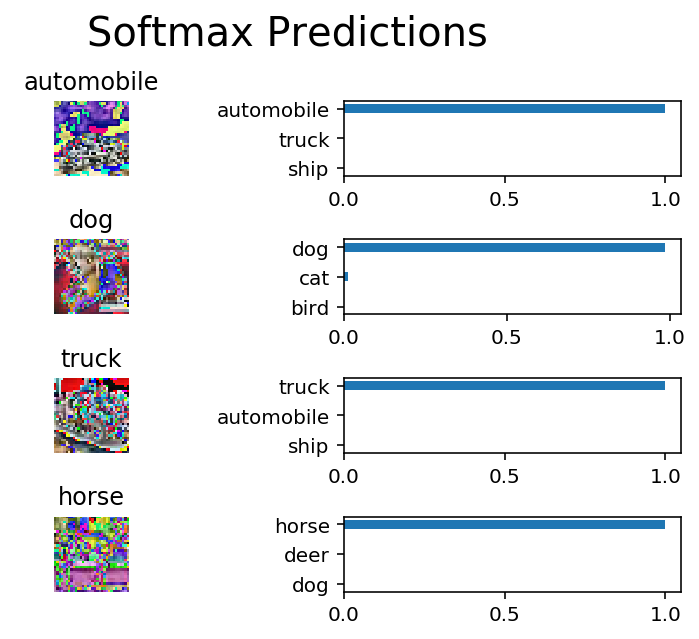

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

batch_size = 128

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    test_features = test_features.astype(np.float32)
    batch_mean = np.mean(test_features)
    batch_std = np.std(test_features)
    for ii in range(test_features.shape[0]):
        test_features[ii,:,:,:] = (test_features[ii,:,:,:] - batch_mean) / batch_std
    
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()